In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp



# Set global options
warnings.filterwarnings("ignore")
plt.style.use('seaborn-darkgrid')
%matplotlib inline


In [31]:
calendar_df = pd.read_csv('calendar.csv')

In [32]:
calendar_df.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [33]:
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  

calendar_df = downcast(calendar_df)

In [34]:
calendar_df.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [35]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1969 non-null   datetime64[ns]
 1   wm_yr_wk      1969 non-null   int16         
 2   weekday       1969 non-null   category      
 3   wday          1969 non-null   int8          
 4   month         1969 non-null   int8          
 5   year          1969 non-null   int16         
 6   d             1969 non-null   category      
 7   event_name_1  162 non-null    category      
 8   event_type_1  162 non-null    category      
 9   event_name_2  5 non-null      category      
 10  event_type_2  5 non-null      category      
 11  snap_CA       1969 non-null   int8          
 12  snap_TX       1969 non-null   int8          
 13  snap_WI       1969 non-null   int8          
dtypes: category(6), datetime64[ns](1), int16(2), int8(5)
memory usage: 128.3 KB


In [36]:
calendar_df.describe()

,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI
count,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000
mean,11347.086338,3.997461,6.325546,2013.288471,0.330117,0.330117,0.330117
std,155.277043,2.001141,3.416864,1.580198,0.470374,0.470374,0.470374
min,11101.000000,1.000000,1.000000,2011.000000,0.000000,0.000000,0.000000
25%,11219.000000,2.000000,3.000000,2012.000000,0.000000,0.000000,0.000000
50%,11337.000000,4.000000,6.000000,2013.000000,0.000000,0.000000,0.000000
75%,11502.000000,6.000000,9.000000,2015.000000,1.000000,1.000000,1.000000
max,11621.000000,7.000000,12.000000,2016.000000,1.000000,1.000000,1.000000


***Occurance of Events***

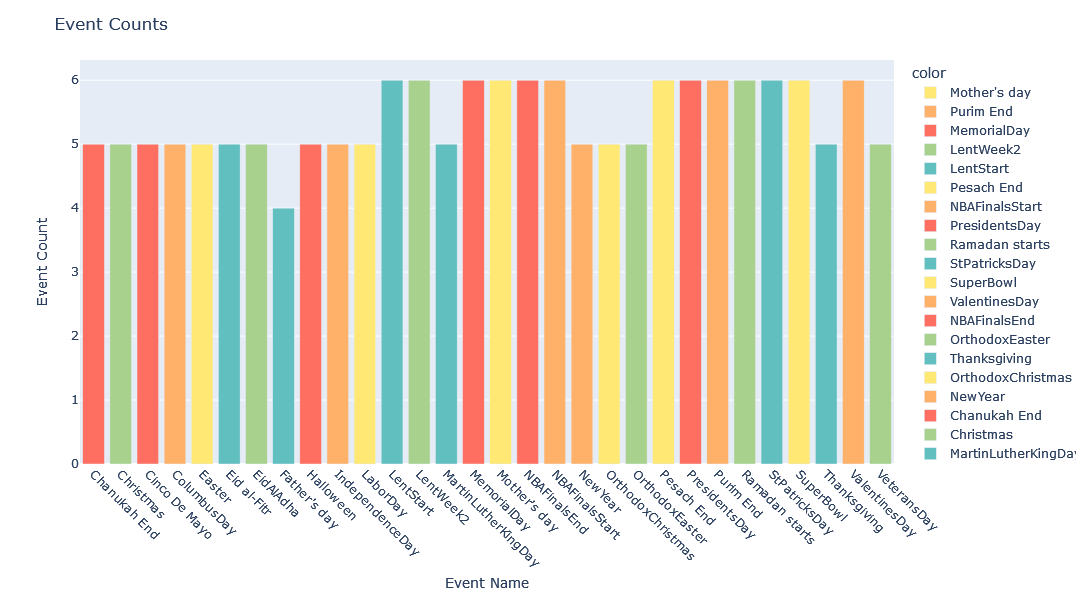

In [37]:
unique_events = calendar_df['event_name_1'].unique()
event_counts = calendar_df['event_name_1'].value_counts()

custom_colors = ['#FFE873', '#FFB169', '#FF6F61', '#A9D18E', '#61C0BF']

fig = px.bar(
    calendar_df, x=event_counts.index, y=event_counts.values,
    labels={'Event Name': 'Event Name', 'Event Count': 'Event Count'},
    width=1000, height=600,
    color=event_counts.index,  
    color_discrete_sequence=custom_colors,  
)
fig.update_xaxes(tickangle=45, categoryorder='category ascending')  
fig.update_layout(title='Event Counts', xaxis_title='Event Name', yaxis_title='Event Count')
fig.show()


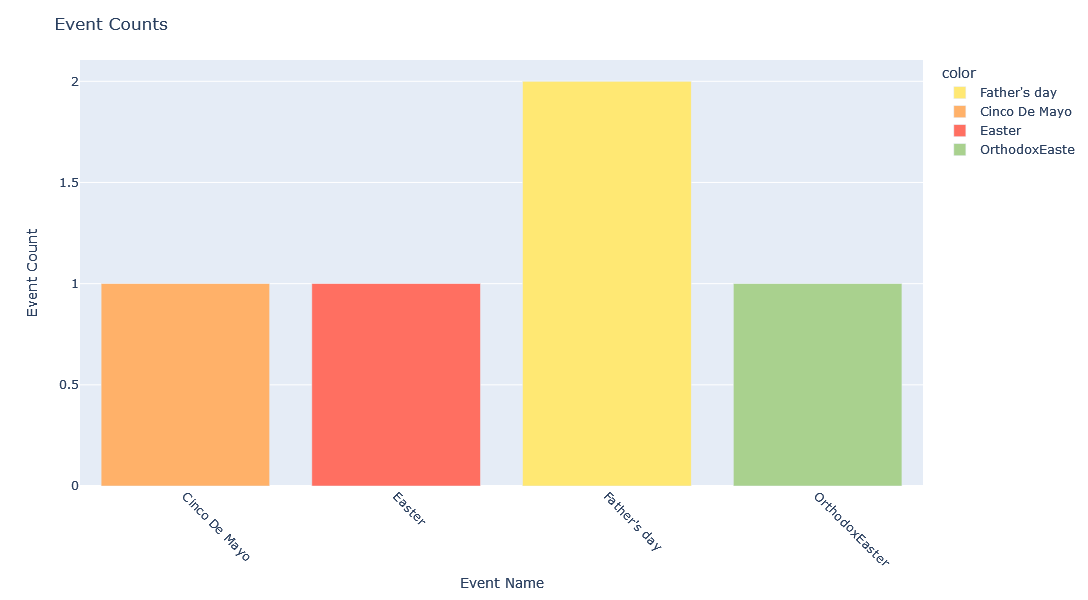

In [57]:
unique_events = calendar_df['event_name_2'].unique()
event_counts = calendar_df['event_name_2'].value_counts()

custom_colors = ['#FFE873', '#FFB169', '#FF6F61', '#A9D18E', '#61C0BF']

fig = px.bar(
    calendar_df, x=event_counts.index, y=event_counts.values,
    labels={'Event Name': 'Event Name', 'Event Count': 'Event Count'},
    width=1000, height=600,
    color=event_counts.index,  
    color_discrete_sequence=custom_colors,  
)
fig.update_xaxes(tickangle=45, categoryorder='category ascending')  
fig.update_layout(title='Event Counts', xaxis_title='Event Name', yaxis_title='Event Count')
fig.show()


***This plot shows how often different events_1 and  occur.***

***Monthly SNAP Distribution For California***

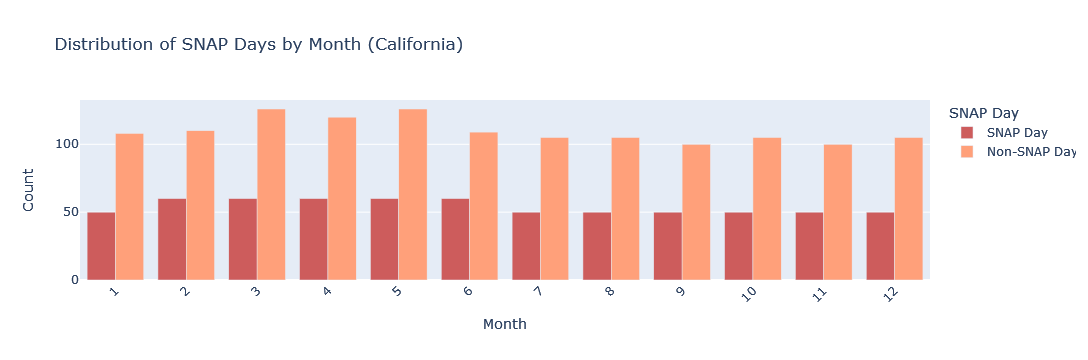

In [38]:
import plotly.graph_objects as go

months =['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']

snap_counts = calendar_df.groupby(['month', 'snap_CA']).size().unstack(fill_value=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=months,
    y=snap_counts[1],  
    name='SNAP Day',
    marker_color='indianred'
))
fig.add_trace(go.Bar(
    x=months,
    y=snap_counts[0],  
    name='Non-SNAP Day',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_xaxes(title='Month')
fig.update_yaxes(title='Count')
fig.update_layout(title='Distribution of SNAP Days by Month (California)')
fig.update_layout(legend_title='SNAP Day')

fig.show()


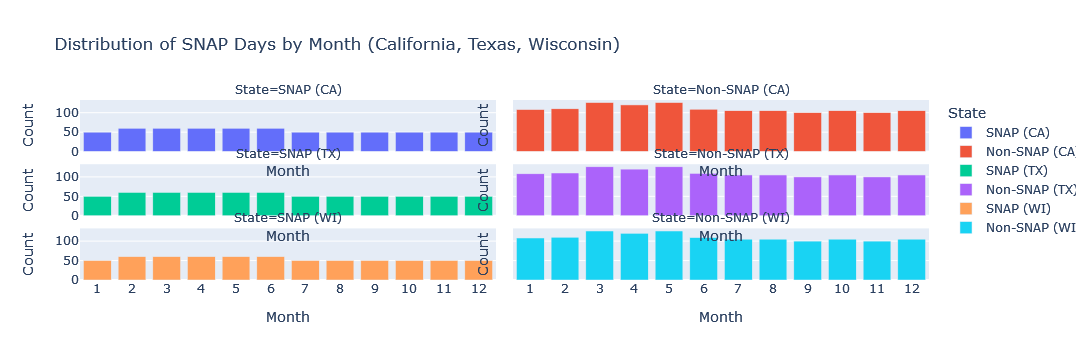

In [39]:
import plotly.express as px

# Define months
months = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']

# Group the data by month and state
snap_counts_CA = calendar_df[calendar_df['snap_CA'] == 1].groupby('month').size()
non_snap_counts_CA = calendar_df[calendar_df['snap_CA'] == 0].groupby('month').size()
snap_counts_TX = calendar_df[calendar_df['snap_TX'] == 1].groupby('month').size()
non_snap_counts_TX = calendar_df[calendar_df['snap_TX'] == 0].groupby('month').size()
snap_counts_WI = calendar_df[calendar_df['snap_WI'] == 1].groupby('month').size()
non_snap_counts_WI = calendar_df[calendar_df['snap_WI'] == 0].groupby('month').size()

# Create a DataFrame for the data
data = pd.DataFrame({
    'Month': months * 6,
    'Count': list(snap_counts_CA) + list(non_snap_counts_CA) +
             list(snap_counts_TX) + list(non_snap_counts_TX) +
             list(snap_counts_WI) + list(non_snap_counts_WI),
    'State': ['SNAP (CA)'] * 12 + ['Non-SNAP (CA)'] * 12 +
             ['SNAP (TX)'] * 12 + ['Non-SNAP (TX)'] * 12 +
             ['SNAP (WI)'] * 12 + ['Non-SNAP (WI)'] * 12
})

# Create the plot using Plotly Express
fig = px.bar(
    data,
    x='Month',
    y='Count',
    color='State',
    facet_col='State',
    facet_col_wrap=2,
    title='Distribution of SNAP Days by Month (California, Texas, Wisconsin)',
    labels={'Count': 'Count'},
    category_orders={"Month": months}
)

# Update layout
fig.update_xaxes(title='Month')
fig.update_yaxes(title='Count')

# Show the plot
fig.show()


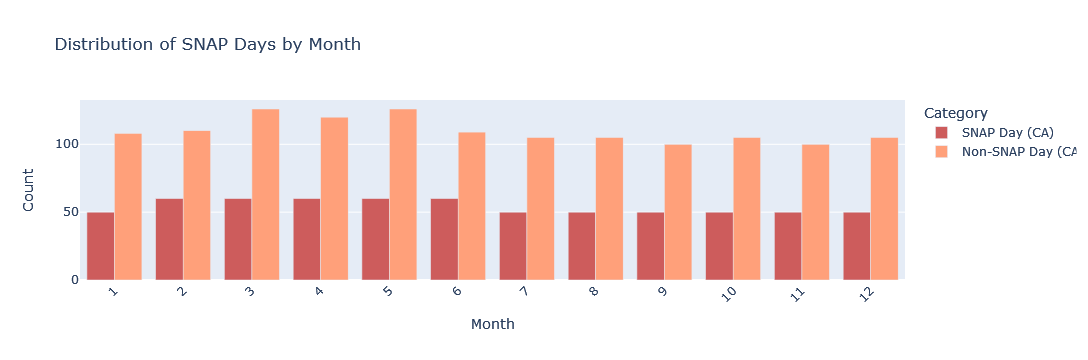

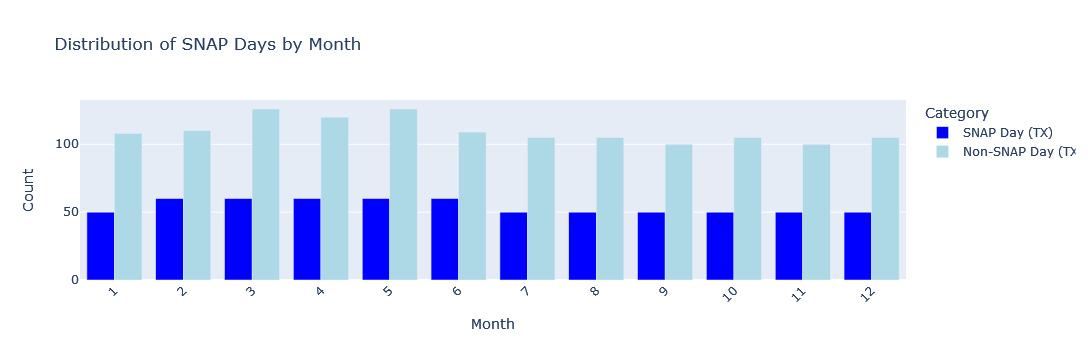

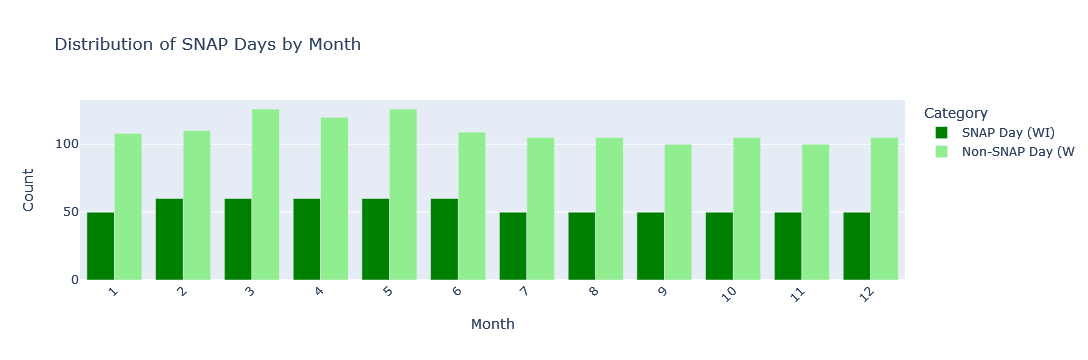

In [40]:
import plotly.graph_objects as go

# Define months
months = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']

# Group the data by month and state for all three states
snap_counts_CA = calendar_df[calendar_df['snap_CA'] == 1].groupby('month').size()
non_snap_counts_CA = calendar_df[calendar_df['snap_CA'] == 0].groupby('month').size()
snap_counts_TX = calendar_df[calendar_df['snap_TX'] == 1].groupby('month').size()
non_snap_counts_TX = calendar_df[calendar_df['snap_TX'] == 0].groupby('month').size()
snap_counts_WI = calendar_df[calendar_df['snap_WI'] == 1].groupby('month').size()
non_snap_counts_WI = calendar_df[calendar_df['snap_WI'] == 0].groupby('month').size()

# Create separate figures for each state
fig_CA = go.Figure()
fig_CA.add_trace(go.Bar(
    x=months,
    y=snap_counts_CA,
    name='SNAP Day (CA)',
    marker_color='indianred'
))
fig_CA.add_trace(go.Bar(
    x=months,
    y=non_snap_counts_CA,
    name='Non-SNAP Day (CA)',
    marker_color='lightsalmon'
))

fig_TX = go.Figure()
fig_TX.add_trace(go.Bar(
    x=months,
    y=snap_counts_TX,
    name='SNAP Day (TX)',
    marker_color='blue'
))
fig_TX.add_trace(go.Bar(
    x=months,
    y=non_snap_counts_TX,
    name='Non-SNAP Day (TX)',
    marker_color='lightblue'
))

fig_WI = go.Figure()
fig_WI.add_trace(go.Bar(
    x=months,
    y=snap_counts_WI,
    name='SNAP Day (WI)',
    marker_color='green'
))
fig_WI.add_trace(go.Bar(
    x=months,
    y=non_snap_counts_WI,
    name='Non-SNAP Day (WI)',
    marker_color='lightgreen'
))

# Update layout for each state's plot
for fig in [fig_CA, fig_TX, fig_WI]:
    fig.update_layout(barmode='group', xaxis_tickangle=-45)
    fig.update_xaxes(title='Month')
    fig.update_yaxes(title='Count')
    fig.update_layout(title='Distribution of SNAP Days by Month')
    fig.update_layout(legend_title='Category')

# Show the plots
fig_CA.show()
fig_TX.show()
fig_WI.show()


***Yearly SNAP Comparison***

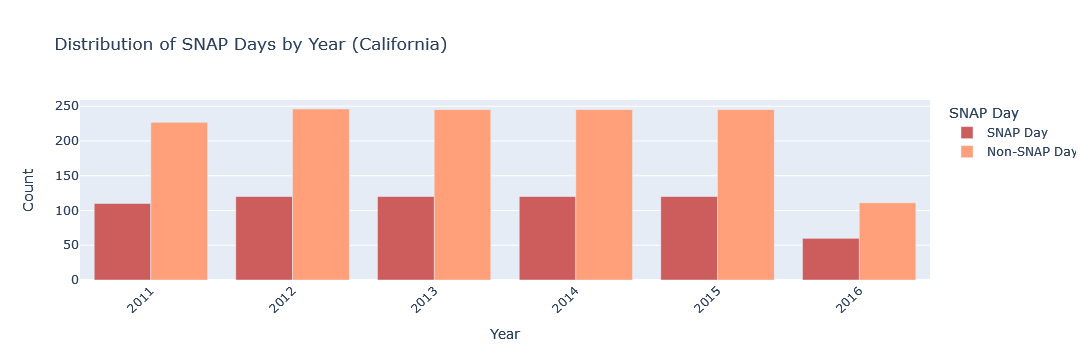

In [41]:

years =['2011', '2012', '2013', '2014', '2015', '2016']

snap_counts = calendar_df.groupby(['year', 'snap_CA']).size().unstack(fill_value=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=years,
    y=snap_counts[1],  
    name='SNAP Day',
    marker_color='indianred'
))
fig.add_trace(go.Bar(
    x=years,
    y=snap_counts[0],  
    name='Non-SNAP Day',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_xaxes(title='Year')
fig.update_yaxes(title='Count')
fig.update_layout(title='Distribution of SNAP Days by Year (California)')
fig.update_layout(legend_title='SNAP Day')

fig.show()


***Examine how events impact the occurrence of SNAP days.This plot illustrates how events influence the occurrence of SNAP and non-SNAP days***

***This plot helps us observe monthly trends in SNAP days for each state.***

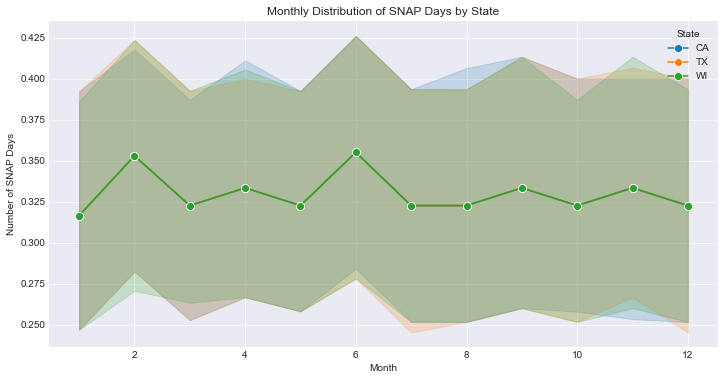

In [42]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='snap_CA', data=calendar_df, label='CA', marker='o', markersize=8)
sns.lineplot(x='month', y='snap_TX', data=calendar_df, label='TX', marker='o', markersize=8)
sns.lineplot(x='month', y='snap_WI', data=calendar_df, label='WI', marker='o', markersize=8)
plt.xlabel('Month')
plt.ylabel('Number of SNAP Days')
plt.title('Monthly Distribution of SNAP Days by State')
plt.legend(title='State', loc='upper right')
plt.show()


***This plot displays the average number of SNAP days for each day of the week in each state.***

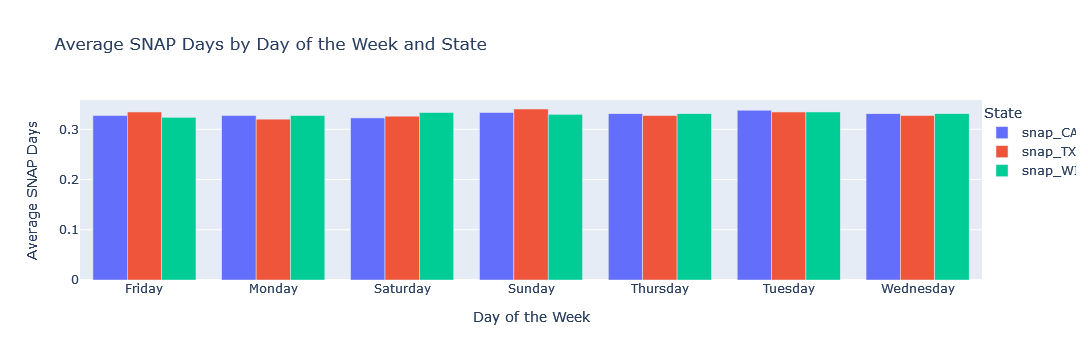

In [43]:
day_of_week_snap = calendar_df.groupby('weekday')[['snap_CA', 'snap_TX', 'snap_WI']].mean().reset_index()

fig = px.bar(
    day_of_week_snap,
    x='weekday',
    y=['snap_CA', 'snap_TX', 'snap_WI'],
    labels={'weekday': 'Day of the Week', 'value': 'Average SNAP Days'},
    title='Average SNAP Days by Day of the Week and State'
)

fig.update_xaxes(title='Day of the Week')
fig.update_yaxes(title='Average SNAP Days')
fig.update_layout(
    legend_title='State',
    barmode='group',
    legend=dict(x=1, y=1)
)

fig.show()


***Explore the types of events (e.g., cultural, national, religious) and their distribution.***

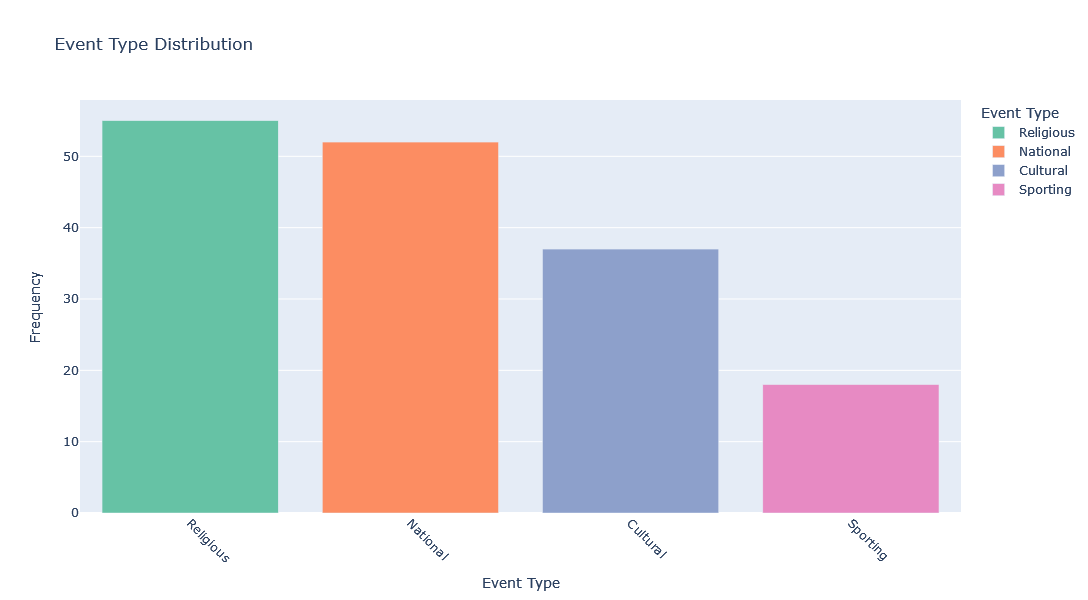

In [44]:
event_type_counts = calendar_df['event_type_1'].value_counts().reset_index()
event_type_counts.columns = ['Event Type', 'Frequency']

fig = px.bar(
    event_type_counts,
    x='Event Type',
    y='Frequency',
    title='Event Type Distribution',
    color='Event Type',  
    color_discrete_sequence=px.colors.qualitative.Set2,  
    category_orders={'Event Type': event_type_counts['Event Type'].tolist()},  
)

fig.update_xaxes(title='Event Type', tickangle=45)
fig.update_yaxes(title='Frequency')

fig.update_layout(height=600)

fig.show()

***Analyze whether events have an impact on the occurrence of SNAP days.***

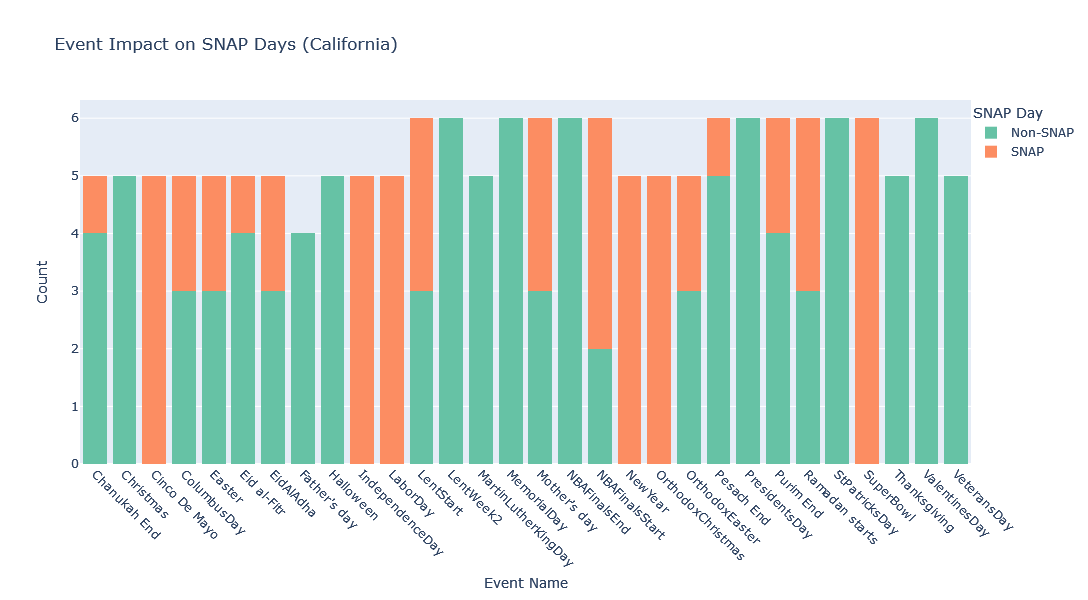

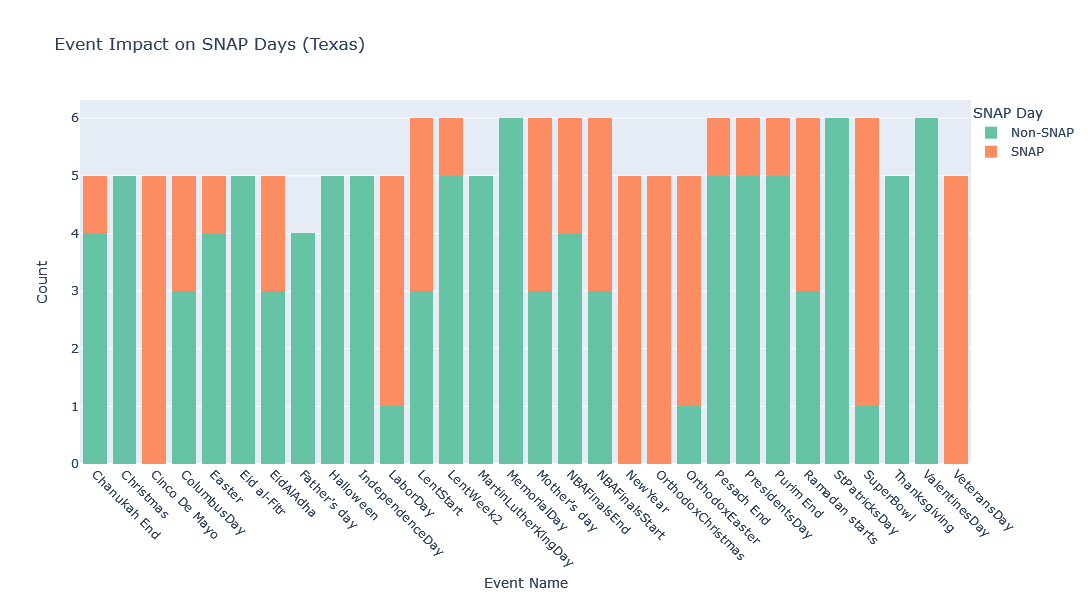

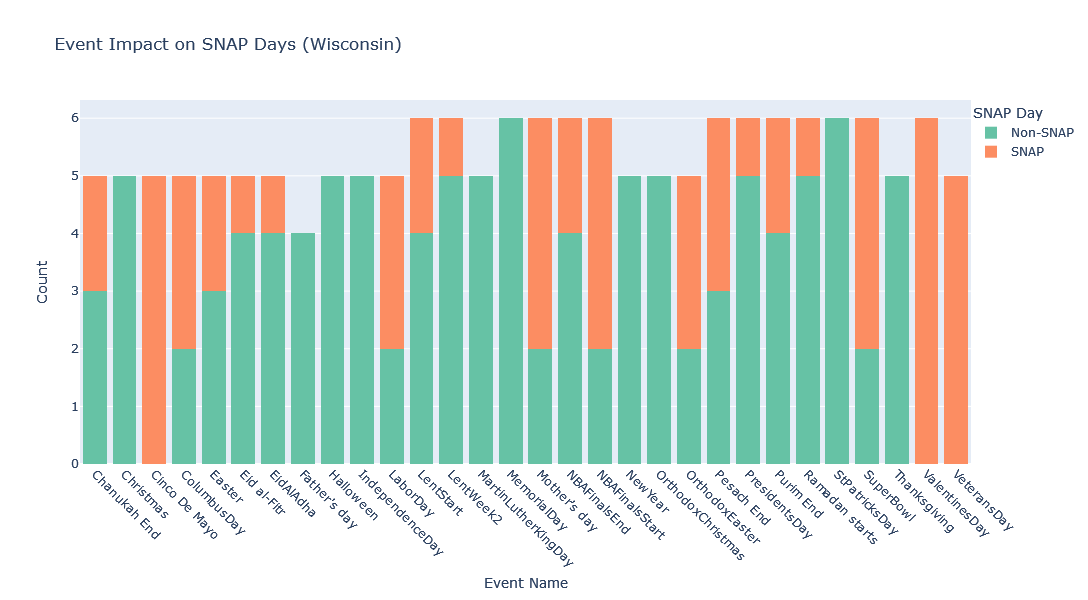

In [45]:
import plotly.express as px

# Group the data by event name and SNAP status for all three states
event_snap_counts_CA = calendar_df.groupby(['event_name_1', 'snap_CA'])['d'].count().unstack().fillna(0).reset_index()
event_snap_counts_CA.columns = ['Event Name', 'Non-SNAP', 'SNAP']

event_snap_counts_TX = calendar_df.groupby(['event_name_1', 'snap_TX'])['d'].count().unstack().fillna(0).reset_index()
event_snap_counts_TX.columns = ['Event Name', 'Non-SNAP', 'SNAP']

event_snap_counts_WI = calendar_df.groupby(['event_name_1', 'snap_WI'])['d'].count().unstack().fillna(0).reset_index()
event_snap_counts_WI.columns = ['Event Name', 'Non-SNAP', 'SNAP']

# Create bar charts for each state
fig_CA = px.bar(
    event_snap_counts_CA,
    x='Event Name',
    y=['Non-SNAP', 'SNAP'],
    title='Event Impact on SNAP Days (California)',
    labels={'Event Name': 'Event Name', 'value': 'Count'},
    color_discrete_sequence=px.colors.qualitative.Set2,
)

fig_TX = px.bar(
    event_snap_counts_TX,
    x='Event Name',
    y=['Non-SNAP', 'SNAP'],
    title='Event Impact on SNAP Days (Texas)',
    labels={'Event Name': 'Event Name', 'value': 'Count'},
    color_discrete_sequence=px.colors.qualitative.Set2,
)

fig_WI = px.bar(
    event_snap_counts_WI,
    x='Event Name',
    y=['Non-SNAP', 'SNAP'],
    title='Event Impact on SNAP Days (Wisconsin)',
    labels={'Event Name': 'Event Name', 'value': 'Count'},
    color_discrete_sequence=px.colors.qualitative.Set2,
)

# Update layout for each state's plot
for fig in [fig_CA, fig_TX, fig_WI]:
    fig.update_xaxes(title='Event Name', tickangle=45)
    fig.update_yaxes(title='Count')
    fig.update_layout(
        barmode='stack',
        height=600,
    )
    fig.update_traces(marker_line_width=0, marker_line_color='rgb(8,48,107)')  # Remove marker lines
    fig.update_layout(legend_title='SNAP Day', legend=dict(title='SNAP Day', x=1, y=1))

# Show the plots
fig_CA.show()
fig_TX.show()
fig_WI.show()


***Analyze the distribution of events by month to identify any seasonality.***

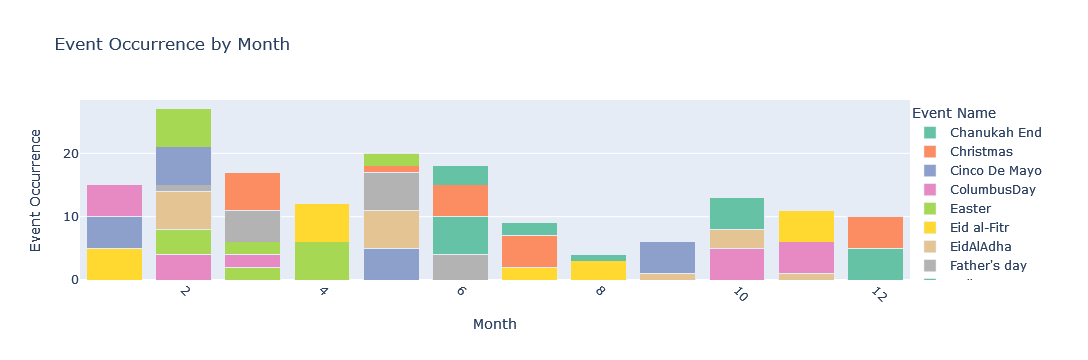

In [46]:
event_counts_monthly = calendar_df.groupby(['month', 'event_name_1'])['d'].count().unstack().fillna(0).reset_index()

fig = px.bar(
    event_counts_monthly,
    x='month',
    y=event_counts_monthly.columns[1:],  
    title='Event Occurrence by Month',
    labels={'month': 'Month', 'value': 'Event Occurrence'},
    color_discrete_sequence=px.colors.qualitative.Set2,  
)

fig.update_xaxes(title='Month', tickangle=45)
fig.update_yaxes(title='Event Occurrence')

fig.update_layout(barmode='stack')  

fig.update_layout(legend_title='Event Name', legend=dict(title='Event Name', x=1, y=1))

fig.show()


***Analyze the distribution of events by Week to identify any seasonality.***

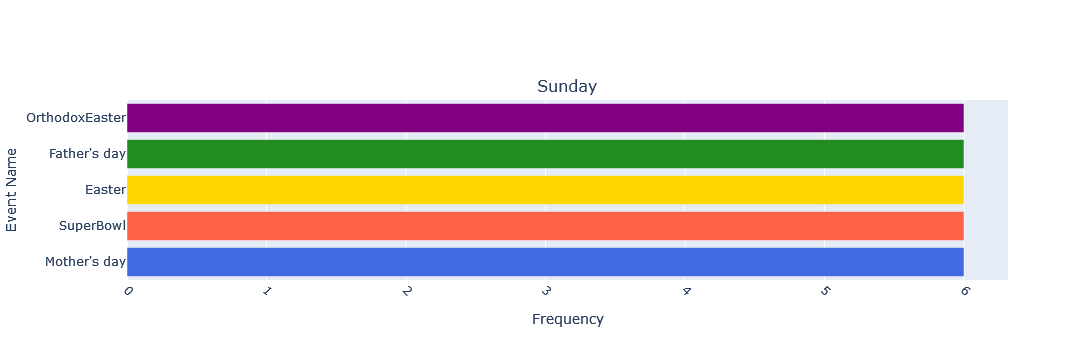

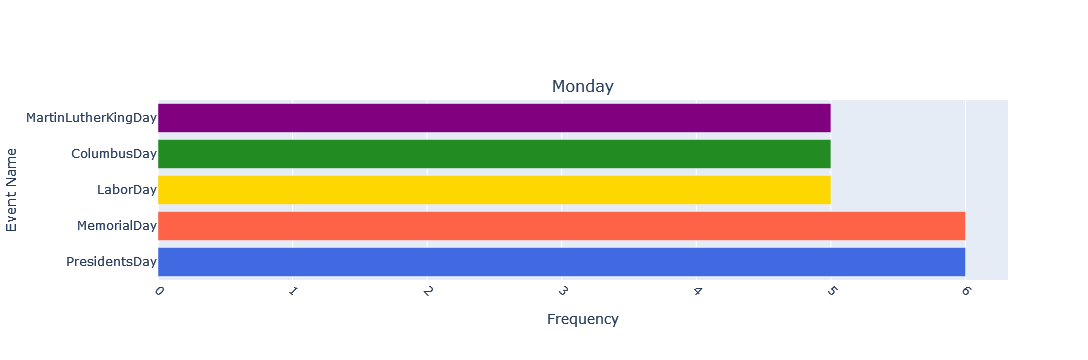

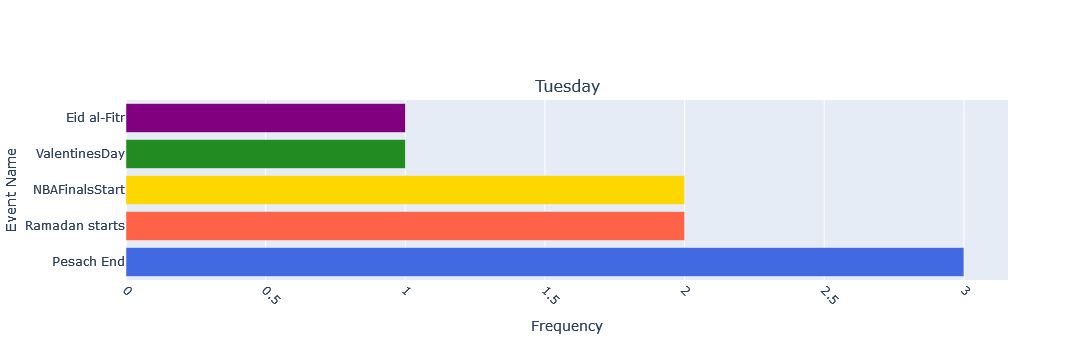

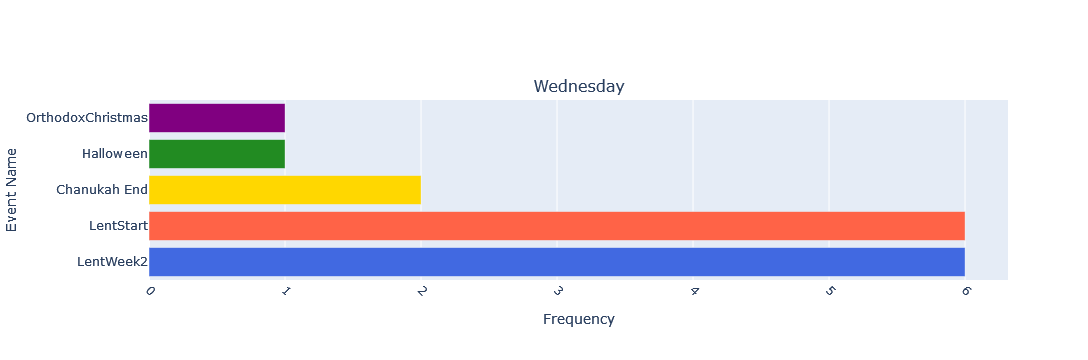

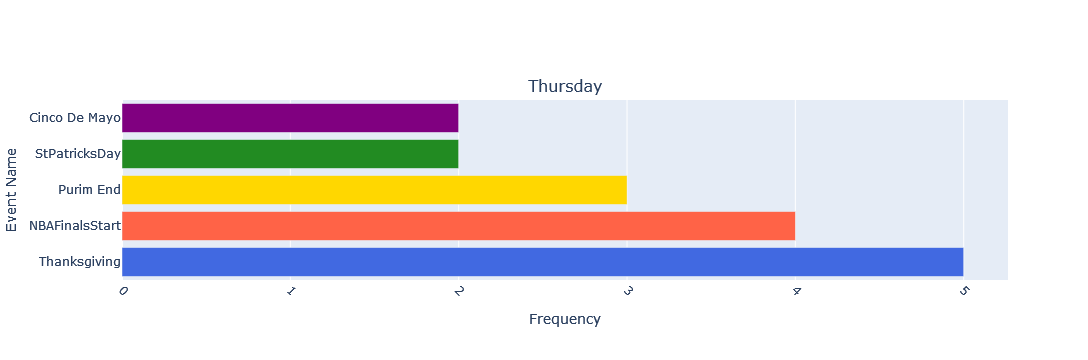

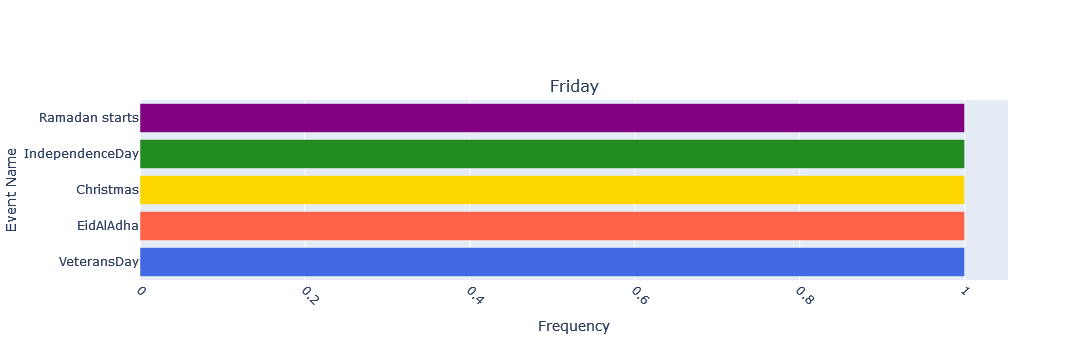

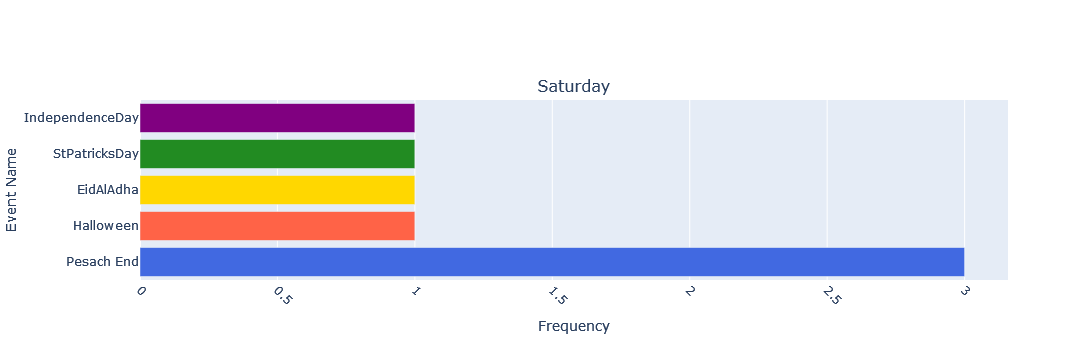

In [47]:
colors = ['royalblue', 'tomato', 'gold', 'forestgreen', 'purple']
days_of_week = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

figs = []

for i, day in enumerate(days_of_week, 1):
    fig = sp.make_subplots(rows=1, cols=1, subplot_titles=[day], vertical_spacing=0.15)
    day_df = calendar_df[calendar_df['weekday'] == day]
    event_counts = day_df[['event_name_1', 'event_name_2']].apply(lambda x: x.value_counts()).fillna(0).sum(axis=1)
    top_events = event_counts.sort_values(ascending=False).head(5)
    
    trace = go.Bar(
        x=top_events.values,
        y=top_events.index,
        orientation='h',
        marker=dict(color=colors)  
    )
    
    fig.add_trace(trace)

    fig.update_layout(
        xaxis=dict(title='Frequency'),
        yaxis=dict(title='Event Name'),
        showlegend=False,
        height=300  
    )

    fig.update_xaxes(title_text='Frequency', tickangle=45)
    figs.append(fig)

for fig in figs:
    fig.show()


***Create Some Features***

In [48]:
calendar_df['date'] = pd.to_datetime(calendar_df['date'])
calendar_df['is_weekend'] = calendar_df['wday'].isin([1, 2]).astype(int)
calendar_df['is_holiday'] = calendar_df['event_type_1'].isin(['National', 'Religious', 'Cultural']).astype(int)

***In EDA I found that February, March, April, May are the high sale months. so I am going to make one feature to represent high sale month.***

In [49]:
f=lambda x: 1 if x==2 or x==3 or x==4 or x==5 else 0
calendar_df['is_high_sale_months']=calendar_df['month'].map(f) 

***In EDA I found that Friday, Saturday, Sunday are the high sale day every week. so I am going to make a feature to represent high sale day.***

In [50]:
f=lambda x: 1 if x==7 or x==1 or x==2 else 0
calendar_df['is_high_sale_day']=calendar_df['wday'].map(f) 

***in EDA I found in every Christmas sale is almost zero.so I am going to make a feature to represent whether day having Christmas or not.***

In [51]:
f=lambda x: 1 if x=='Christmas' else 0
calendar_df['is_christmas']=calendar_df['event_name_1'].map(f)

In [55]:
calendar_df

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,is_weekend,is_holiday,is_high_sale_months,is_high_sale_day,is_christmas
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,1,0,0,1,NaN
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,1,0,0,1,NaN
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,NaN
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,0,0,1,0,NaN
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,0,0,1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1,0,0,0,0,NaN
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,NaN
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0,0,0,0,1,NaN
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0,1,0,0,1,NaN
